# **Multivariate time series using LSTM**

## **Introduction**

In this Jupyter notebook, we use LSTM to build a model for multivariate time series of the taxi trips, for the regions of Chicago. In this scenario, we consider only the inter-region taxi trips between the different regions. The idea is to focus the LSMT model to undertand better the interactions between the cities and predict better future taxi trips. 

To do that, we build a tensor containing a matrix representing the new-flows and end-flows of taxis for each region, at a given hour. Each row of the matrix is a pair [new-flow, end-flow] for a given region, at hour t.

Then, for simplification, and pre-test, we build a corrrelation matrix between pairs of regions. Using a correlation threshold, we filter the regions with the highest correlations which should help the LSTM model understand better the interactions.

First, let's setup the environment.

## **Setting up the environment**

In [ ]:
#Libraries needed in this notebook
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import numpy as np
import timeSeriesMatrix

#to track the time for the LSTM training part
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=0298ed76262888af2182f6dde93aa7d85b4972d645f2766aeb2900c6d30183f5
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [ ]:
regions_with_minimum_taxi_trips = [[26, 365168.0], [53, 26872.0], [60, 459962.0], [62, 15995.0], [65, 18050.0], [66, 2536978.0], [67, 21184.0], [68, 59604.0], [72, 750790.0], [73, 96074.0], [75, 155855.0], [76, 716215.0], [77, 1399092.0], [78, 496385.0], [80, 30788.0], [82, 64346.0], [83, 427156.0], [88, 86480.0], [100, 62372.0], [125, 107300.0]]

regions_selected_array = []

for elem in regions_with_minimum_taxi_trips:
  regions_selected_array.append(elem[0])

print("List of region IDs with minimum taxi trips and representing 98% of all taxi flows")
print(regions_selected_array)

List of region IDs with minimum taxi trips and representing 98% of all taxi flows
[26, 53, 60, 62, 65, 66, 67, 68, 72, 73, 75, 76, 77, 78, 80, 82, 83, 88, 100, 125]
time: 5.38 ms


In [ ]:
import timeSeriesAnalysis
import timefunctions
from numpy import array

def returnListOfRegionsWithMinimumTaxiTrips(taxiTripsThreshold):
  regionsFilteredArray = []
  for regionTaxiTripPair in regions_with_minimum_taxi_trips:
    if regionTaxiTripPair[1] >= taxiTripsThreshold:
      regionsFilteredArray.append(regionTaxiTripPair[0])
  return regionsFilteredArray

def returnEmptyTaxiTripsTensor(numberOfRegionIDs,timePeriodinHour = 24*365):
  emptyNewFlowEndFlowMatrix = [0 for j in range(2) for i in range(numberOfRegionIDs)]
  emptyTensor = [emptyNewFlowEndFlowMatrix for j in range(timePeriodinHour)]
  return emptyTensor

def fillSimpleTaxiTripsTensorWith(taxiTripsTensor, regionsFilteredArray, dataframe, interRegionsOnly):
  
  for index, row in dataframe.iterrows():
    pickupIndex = timeSeriesAnalysis.returnRegionIndexinArray( row['pickup_regionIDs'], regionsFilteredArray )
    dropoffIndex = timeSeriesAnalysis.returnRegionIndexinArray( row['dropoff_regionIDs'], regionsFilteredArray )
    
    pickupTimestamp = [ row['pickup_month'], row['pickup_day'], row['pickup_hour']]
    pickupTimeIndex = timefunctions.mappingFromTimestampToHourlyVector(pickupTimestamp) 

    dropoffTimestamp = [ row['dropoff_month'], row['dropoff_day'], row['dropoff_hour']]
    dropoffTimeIndex = timefunctions.mappingFromTimestampToHourlyVector(dropoffTimestamp) 
    
    if interRegionsOnly == True:
      if pickupIndex >= 0 and  dropoffIndex >= 0 and pickupIndex != dropoffIndex:
        prevValue = taxiTripsTensor[pickupTimeIndex][pickupIndex*2]
        taxiTripsTensor[pickupTimeIndex][pickupIndex*2] = prevValue + 1

        prevValue = taxiTripsTensor[dropoffTimeIndex][dropoffIndex*2 + 1]
        taxiTripsTensor[dropoffTimeIndex][dropoffIndex*2 + 1] = prevValue + 1

    else:
      if pickupIndex >= 0 and  dropoffIndex >= 0:
        prevValue = taxiTripsTensor[pickupTimeIndex][pickupIndex*2]
        taxiTripsTensor[pickupTimeIndex][pickupIndex*2] = prevValue + 1

        prevValue = taxiTripsTensor[dropoffTimeIndex][dropoffIndex*2 + 1]
        taxiTripsTensor[dropoffTimeIndex][dropoffIndex*2 + 1] = prevValue + 1

  return taxiTripsTensor

#this function builds a tensor with new-flow and end-flows for each region 
#without knowledge of provenance or destination region
def buildSimpleTaxiTripsTensor(csvFillPathArray, taxiTripsThreshold = 180000, timePeriodinHour = 24*365, interRegionsOnly = True):
  regionsFilteredArray = returnListOfRegionsWithMinimumTaxiTrips(taxiTripsThreshold)
  numberOfRegionIDs = len(regionsFilteredArray)
  taxiTripsTensor = array(returnEmptyTaxiTripsTensor(numberOfRegionIDs,timePeriodinHour))
  
  for csvFilePath in csvFillPathArray:
    dataframe = pd.read_csv(csvFilePath)
    taxiTripsTensor = fillSimpleTaxiTripsTensorWith(taxiTripsTensor, regionsFilteredArray, dataframe, interRegionsOnly)
  
  return taxiTripsTensor

time: 74.3 ms


In [ ]:
csvFillPathArray = ['/content/clean_df_sep.csv', '/content/clean_df_oct.csv', '/content/clean_df_nov.csv']
mintaxiTripsThreshold = 0
taxiTripsTensor = buildSimpleTaxiTripsTensor(csvFillPathArray, taxiTripsThreshold = mintaxiTripsThreshold)

time: 18min 2s


We check that we got the numbers right.

In [ ]:
taxiTripsTensor[24*242:24*242+1]

array([[23,  0,  1,  2, 38, 14,  0,  9,  0,  2, 82, 49,  0,  0,  0,  6,
         7, 22,  0,  3, 18,  4, 16, 26, 33, 14,  3, 16,  0,  0,  0,  1,
         4, 13,  0,  0,  0,  0,  3,  0]])

time: 2.53 ms


Since it took about 18 min tu build that tensor, we save a copy as a csv for future works.

In [ ]:
from numpy import asarray
from numpy import savetxt

CSVFilename = "simpleTaxiTripsTensorSepNov"
data = asarray( taxiTripsTensor )
# save to csv file
CSVFullpath = '/content/' + CSVFilename + '.csv'
savetxt(CSVFullpath, data, delimiter=',')

time: 199 ms


In [ ]:
from numpy import loadtxt
from numpy import asarray

taxiTripsTensor = np.loadtxt("/content/simpleTaxiTripsTensorSepNov.csv", delimiter=',')

time: 293 ms


## **Building the correlation matrix**

We build a single time series for each region as follows: each region will have a single array containing the new flows at each hour, from September to October 2017, followed by the end flows for the same period. Then, we compute the correlation matrix of that region's array with another region's.

In [ ]:
def returnSingleEndFlowNewFlowChainMatrix( startingIndex, endingIndex, fullYearTaxiTripsTensor):
  numberRegionIDs = int(fullYearTaxiTripsTensor.shape[1]/2)
  singleEndFlowNewFlowChainMatrix = []
  
  i = 0
  n = endingIndex

  while i < numberRegionIDs:
    
    j = startingIndex
    newflowchain = []
    endflowchain = []
    while j < endingIndex:
      newflowchain.append(fullYearTaxiTripsTensor[j][i*2])
      endflowchain.append(fullYearTaxiTripsTensor[j][i*2+1])
      j = j + 1
    
    newflowendflowchain = newflowchain + endflowchain
    singleEndFlowNewFlowChainMatrix.append(newflowendflowchain)
    
    i = i + 1

  return singleEndFlowNewFlowChainMatrix

time: 12.8 ms


Below, we make sure to compute the correlation matrix between the regions just for the period September to end of October. We leave the data for November so that the LSTM model can't see them.

In [ ]:
startIndex = 242*24
endIndex = 333*24
endIndexTraining = (242+61)*24

singleEndFlowNewFlowChainMatrix = returnSingleEndFlowNewFlowChainMatrix( startIndex, endIndexTraining, taxiTripsTensor)

time: 29.5 ms


In [ ]:
from scipy.stats import spearmanr
from matplotlib import pyplot

def plotTimeSeriesOneAgainstOne(timeSeries1, timeSeries2):
  pyplot.scatter(timeSeries1, timeSeries2)
  pyplot.show()

def returnCorrelationCoefficient(timeSeries1, timeSeries2):
  #returns coef, p 
  #Samples are correlated (reject H0) p> alpha, alpha = 0.05
  return spearmanr(timeSeries1, timeSeries2)

def returnEmptyCorrelationMatrixFor(numberOfRegionIDs):
  return [[0 for j in range(numberOfRegionIDs)] for i in range(numberOfRegionIDs)]

def buildCorrelationMatrix (singleFlowsTaxiTripsChainMatrix):
  n = len(singleFlowsTaxiTripsChainMatrix)
  i = 0
  correlationMatrix = returnEmptyCorrelationMatrixFor(n)
  while i < n-1:
    correlationMatrix[i][i] = 0
    j = i + 1
    region1TimeSeries = singleFlowsTaxiTripsChainMatrix[i]
    while j < n :
      region2TimeSeries = singleFlowsTaxiTripsChainMatrix[j]
      correlationValue = returnCorrelationCoefficient(region1TimeSeries, region2TimeSeries)
      correlationMatrix[i][j] = abs(int(correlationValue[0] * 100))
      correlationMatrix[j][i] = abs(int(correlationValue[0] * 100))
      j = j + 1
    i = i + 1
  correlationMatrix[i][i] = 0
  return correlationMatrix

time: 22.3 ms


In [ ]:
correlationMatrix = buildCorrelationMatrix (singleEndFlowNewFlowChainMatrix)

time: 298 ms


[Text(0, 0.5, '26'),
 Text(0, 1.5, '53'),
 Text(0, 2.5, '60'),
 Text(0, 3.5, '62'),
 Text(0, 4.5, '65'),
 Text(0, 5.5, '66'),
 Text(0, 6.5, '67'),
 Text(0, 7.5, '68'),
 Text(0, 8.5, '72'),
 Text(0, 9.5, '73'),
 Text(0, 10.5, '75'),
 Text(0, 11.5, '76'),
 Text(0, 12.5, '77'),
 Text(0, 13.5, '78'),
 Text(0, 14.5, '80'),
 Text(0, 15.5, '82'),
 Text(0, 16.5, '83'),
 Text(0, 17.5, '88'),
 Text(0, 18.5, '100'),
 Text(0, 19.5, '125')]

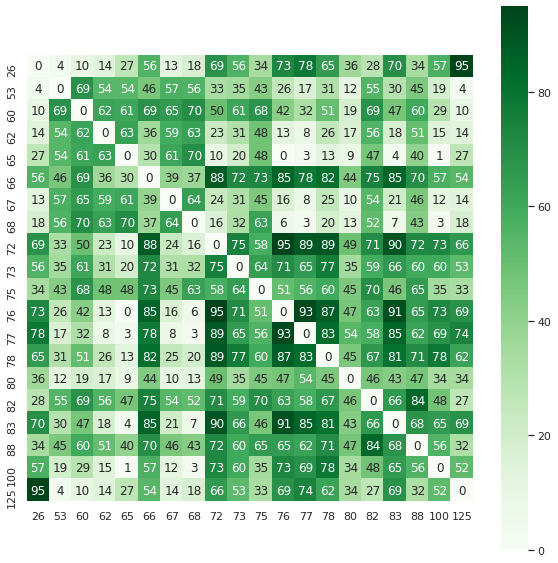

time: 1.68 s


In [ ]:
import seaborn as sns
sns.set()
f, ax = plt.subplots(figsize=(10, 10))
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax = sns.heatmap(correlationMatrix, annot=True, square=True,cmap="Greens")
ax.set_xticklabels(regions_selected_array)
ax.set_yticklabels(regions_selected_array)


In [ ]:
def returnArrayofSimilarRegions(correlationthreshold, correlationMatrixRowArray):
  similarRegionsArray = []
  i = 0
  for correlationValue in correlationMatrixRowArray:
    if correlationValue >= correlationthreshold:
      similarRegionsArray.append(regions_selected_array[i])
    i = i + 1
  return similarRegionsArray

def isRegionInsideSimilarRegionsArray(regionIDvalue, similarRegionsArray):
  i = 0
  for similarRegionsRowArray in similarRegionsArray:
    if regionIDvalue in similarRegionsRowArray:
      return i
    i = i + 1
  return -1

def clusterRegionsBySimilarity(correlationthreshold, correlationmatrix):
  similarRegionsArray = []
  n = len(correlationmatrix)
  i = 0
  while i < n:
    regionIDvalue = regions_selected_array[i]
    index = isRegionInsideSimilarRegionsArray(regionIDvalue, similarRegionsArray)
    similarRegionsArrayRow = returnArrayofSimilarRegions(correlationthreshold, correlationmatrix[i])
    similarRegionsArrayRow.append(regionIDvalue)
    if index >= 0 :
      similarRegionsArrayPrevious = similarRegionsArray[index]
      updatedSimilarRegionsArray = similarRegionsArrayPrevious + similarRegionsArrayRow
      updatedSimilarRegionsArray = list(dict.fromkeys(updatedSimilarRegionsArray))
      similarRegionsArray[index] = updatedSimilarRegionsArray
    else:
      similarRegionsArray.append(similarRegionsArrayRow)
    i = i + 1
  
  return similarRegionsArray

time: 22.4 ms


In [ ]:
similarRegionsArray = clusterRegionsBySimilarity(79, correlationMatrix)

similarRegionsArray

[[125, 26],
 [53],
 [60],
 [62],
 [65],
 [72, 76, 78, 83, 66, 77],
 [67],
 [68],
 [73],
 [75],
 [80],
 [88, 82],
 [100]]

time: 4.13 ms


Now that we clustered the regions according to their correlation matrix, we can then feed each cluster of regions to the LSTM model for training.


## **LSTM for the 3 clusters of regions**

From the previous section, the 3 clusters are: 
1. [125, 26]
2. [72, 76, 78, 83, 66, 77]
3. [88, 82]

For all the other remaining regions, we can explore how to model them, either a single LSTM for end-flows and new-flows, or two LSTM models for the 2 flows, intra-region and inter-regions.

In [ ]:
startIndex = 242*24
endIndex = 333*24
endIndexTraining = 61*24

taxiTripsTensorCopy = taxiTripsTensor[startIndex:endIndex].copy()

time: 1.7 ms


In [ ]:
taxiTripsTensor[startIndex+1]

array([ 6.,  0.,  0.,  0., 21., 29.,  0.,  4.,  0.,  0., 56., 47.,  0.,
        0.,  0.,  0.,  6., 27.,  0.,  3., 13.,  0., 11., 40., 38., 21.,
        3., 11.,  0.,  0.,  0.,  4.,  0.,  6.,  2.,  2.,  0.,  0.,  4.,
        0.])

time: 3.17 ms


In [ ]:
def returnTaxiTripsTensorForCluster(clusterRegionIDsArray, startingIndex, endingIndex, taxiTripsTensor , regionsFilteredArray):
  indexClusterArray = []
  for regionIDvalue in  clusterRegionIDsArray:
    regionIDIndex = timeSeriesAnalysis.returnRegionIndexinArray( regionIDvalue, regionsFilteredArray )
    indexClusterArray.append(regionIDIndex)
  
  clustertaxiTripsTensor = []
  i = startingIndex
  while i < endingIndex:
    clusterTaxiTripsRow = []
    for regionIDindex in indexClusterArray:
      newFlow = taxiTripsTensor[i][regionIDindex*2]
      endFlow = taxiTripsTensor[i][regionIDindex*2 + 1]
      clusterTaxiTripsRow.append(newFlow)
      clusterTaxiTripsRow.append(endFlow)
    clustertaxiTripsTensor.append(clusterTaxiTripsRow)
    i = i + 1
  return clustertaxiTripsTensor

time: 9.83 ms


In [ ]:
clustertaxiTripsTensor = returnTaxiTripsTensorForCluster([82, 88], startIndex, endIndex, taxiTripsTensor, regions_selected_array)

clustertaxiTripsTensor = array(clustertaxiTripsTensor)

clustertaxiTripsTensor.shape

(2184, 4)

time: 14.3 ms


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

taxiTripsTensorCopy = clustertaxiTripsTensor.copy()

scaler = StandardScaler()
scaler.fit(taxiTripsTensorCopy[:endIndexTraining])
scaled_train_data = scaler.transform(taxiTripsTensorCopy)

time: 4.6 ms


In [ ]:
scaled_train_data[:2]

array([[-0.86944006, -1.04571646, -0.96546165, -1.3136587 ],
       [-0.86944006, -0.85268546, -0.66587796, -1.21656435]])

time: 4.91 ms


In [ ]:
import timefeatures

hoursinYear2017Array = timefeatures.retourHourArray("")
dayTypeEncodingArray = timefeatures.returnDayTypeArray('2017-01-01')

feature_1 = hoursinYear2017Array[startIndex:endIndex]
feature_2 = dayTypeEncodingArray[startIndex:endIndex]

feature_1 = array(feature_1)
feature_1 = feature_1.reshape(-1,1)

feature_2 = array(feature_2)
feature_2 = feature_2.reshape(-1,1)

time: 11 ms


In [ ]:
print(scaled_train_data.shape)

print(feature_1.shape)

(2184, 4)
(2184, 1)
time: 1.18 ms


In [ ]:
scaled_train_data_input = np.concatenate((scaled_train_data, feature_1, feature_2), axis=1)

time: 2.66 ms


In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

def returnLSTMModel(hourTrainRange, xtrain, ytrain, batchSize, nfeatures, nweights):
  generator = TimeseriesGenerator(xtrain, ytrain, length=hourTrainRange, batch_size=batchSize)
  lstm_model = Sequential()
  lstm_model.add(LSTM(nweights, activation='relu', input_shape=(hourTrainRange, nfeatures)))
  lstm_model.add(Dense(ytrain.shape[1]))
  lstm_model.compile(optimizer='adam', loss='mse')

  return [lstm_model, generator]

Using TensorFlow backend.


time: 1.8 s


In [ ]:
def returnLSTMForecast(lstm_model, hourTrainRange, nfeatures, forecastPeriodRange, xtrain, featureArray1, featureArray2):
  lstm_predictions_scaled = list()

  batch = xtrain[-hourTrainRange:]

  current_batch = batch.reshape((-1, hourTrainRange, nfeatures))

  j = 0
  for i in range(forecastPeriodRange):   
      lstm_pred = lstm_model.predict(current_batch)[0]

      elem_array = []
      for prediction in lstm_pred:
        elem_array.append(prediction)
      elem_array.append(featureArray1[j])
      elem_array.append(featureArray2[j])

      elem = np.array(elem_array)
      elem = elem.reshape((1, nfeatures))

      lstm_predictions_scaled.append(lstm_pred) 

      current_batch = np.append(current_batch[0] , elem, axis = 0)
      current_batch = current_batch[1:]
      current_batch = current_batch.reshape((-1, hourTrainRange, nfeatures))
      j = j + 1

  return lstm_predictions_scaled

def plotForecastAgaintRealTimeSeries(predictionTimeSeries, targetTimeSeries):
  plt.xlabel("Time in hour") 
  plt.ylabel("Number of taxi trips") 
  plt.title("Forecast in blue against actual time series")
  plt.plot(predictionTimeSeries,'blue', targetTimeSeries, 'g') 
  plt.show()

time: 18.2 ms


In [ ]:
def returnRMSEofTensors(yforecast, y):
  yforecast[yforecast < 0] = 0
  ydifference = (yforecast - y)**2
  rmse = (ydifference.sum()/(y.shape[0]*y.shape[1]))**0.5
  return rmse

def returnRMSEofTensorsForPeriodForecastArray(yforecast, y, periodForecastArray):
  rmseArray = []
  for periodForecast in periodForecastArray:
    rmse = returnRMSEofTensors(yforecast[:periodForecast], y[:periodForecast])
    rmseArray.append(rmse)
  return rmseArray

def returnSumofSquares(yforecast, y):
  yforecast[yforecast < 0] = 0
  ydifference = (yforecast - y)**2
  sumSquares = ydifference.sum()
  return sumSquares

def returnSumofSquaresOfTensorsForPeriodForecastArray(yforecast, y, periodForecastArray):
  sumSquaresArray = []
  for periodForecast in periodForecastArray:
    sumSquares = returnSumofSquares(yforecast[:periodForecast], y[:periodForecast])
    sumSquaresArray.append(sumSquares)
  return sumSquaresArray

time: 18.1 ms


In [ ]:
#period for training
startIndex = 0
endIndexTraining = 61*24
endIndex = endIndexTraining

#parameters for the LSTM
n_input = 6
n_features= scaled_train_data_input.shape[1]
batch_size = 1
number_epochs = 25
period_to_forecast = 24*7*2
n_weights = (scaled_train_data_input.shape[1] - 2 )*200
print("neurons =", n_weights)

rmseForecastingPeriodArrays = [5, 10, 12, 16, 20, 24, 24*7, 24*7*2]

#creating instance of LSTM model
lstm_model, generator = returnLSTMModel(n_input, scaled_train_data_input[startIndex:endIndex], scaled_train_data[startIndex:endIndex], batch_size, n_features, n_weights)
  
#training
lstm_model.fit_generator(generator, epochs=number_epochs)

neurons = 800
Epoch 1/25
1458/1458 [==============================] - 111s 76ms/step - loss: 0.4266
Epoch 2/25
1458/1458 [==============================] - 114s 78ms/step - loss: 0.3366
Epoch 3/25
1458/1458 [==============================] - 102s 70ms/step - loss: 0.3117
Epoch 4/25
1458/1458 [==============================] - 82s 56ms/step - loss: 0.2990
Epoch 5/25
1458/1458 [==============================] - 83s 57ms/step - loss: 0.2844
Epoch 6/25
1458/1458 [==============================] - 104s 71ms/step - loss: 0.2796
Epoch 7/25
1458/1458 [==============================] - 126s 87ms/step - loss: 0.2711
Epoch 8/25
1458/1458 [==============================] - 103s 71ms/step - loss: 0.2674
Epoch 9/25
1458/1458 [==============================] - 89s 61ms/step - loss: 0.2641
Epoch 10/25
1458/1458 [==============================] - 89s 61ms/step - loss: 0.2677
Epoch 11/25
1458/1458 [==============================] - 89s 61ms/step - loss: 0.2587
Epoch 12/25
1458/1458 [====================

time: 36min 21s


In [ ]:
feature1 =  feature_1[endIndex:endIndex + period_to_forecast]
feature2 =  feature_2[endIndex:endIndex + period_to_forecast]

lstm_predictions_scaled = returnLSTMForecast(lstm_model, n_input, n_features, period_to_forecast, scaled_train_data_input[startIndex:endIndex], feature1, feature2)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
y_forecast = lstm_predictions.copy()
y_ = clustertaxiTripsTensor[endIndex:endIndex + period_to_forecast].copy()

rmse_array = returnRMSEofTensorsForPeriodForecastArray(y_forecast, y_, rmseForecastingPeriodArrays)

print("RMSE results")
print("Region IDs :", [82, 88])
print("Forecasting period in hours :", rmseForecastingPeriodArrays)
print("RMSE array :", rmse_array)

RMSE results
Region IDs : [82, 88]
Forecasting period in hours : [5, 10, 12, 16, 20, 24, 168, 336]
RMSE array : [1.2582665481768631, 2.5694880202865042, 3.7266969581242573, 4.625166228066768, 5.2595847967652425, 6.301286930705973, 6.95650396352625, 6.811412481674546]
time: 1.42 s


**This Jupyter notebook was run on various instances to get the results for the other 2 clusters. Below are the results from those instances.**


RMSE results after 25 epochs

Region IDs : 26, 125

Forecasting period in hours  [5, 10, 12, 16, 20, 24, 168, 336]

RMSE array  [3.3974140049175254, 20.538825521655404, 32.49977146424823, 40.38558552463924, 41.794187993651335, 40.48633146074777, 34.046557520625356, 30.22450277446945]


RMSE results after 32 epochs

Region IDs : [66, 72, 76, 77, 78, 83]

Forecasting period in hours : [5, 10, 12, 16, 20, 24, 168, 336]

RMSE array : [5.100372731301856, 72.27703287801988, 86.45610673600409, 97.94215341864783, 107.71195901013753, 113.1433467850136, 74.02630859366127, 68.22244923746031]



## **Forecasting new-flows and end-flows for each region with LSTM**

In this section, we build LSTM models for each of the 20 regions. The time series fed to the LSTM are the new-flows and end-flows of each region. An important thing to note is that we consider only the taxi-trips happening between the 20 regions, we exclude the other 70 regions of Chicago. The idea is to create a closed system which should help the LSTM understand better the taxi flows.  

In [ ]:
csvFillPathArray = ['/content/clean_df_sep.csv', '/content/clean_df_oct.csv', '/content/clean_df_nov.csv']
mintaxiTripsThreshold = 0
taxiTripsTensor = buildSimpleTaxiTripsTensor(csvFillPathArray, taxiTripsThreshold = mintaxiTripsThreshold, interRegionsOnly=False)

time: 18min 39s


We check that we get the right numbers and that we included the intra-regions taxi trips. 

In [ ]:
taxiTripsTensor[24*242:24*242+1]

array([[ 26,   3,   1,   2,  47,  19,   0,   9,   0,   2, 136, 101,   0,
          0,   0,   6,  16,  31,   0,   3,  20,   6,  16,  26,  35,  15,
          4,  17,   0,   0,   0,   1,   4,  13,   0,   0,   0,   0,   3,
          0]])

time: 5.27 ms


We save the data for future works.

In [ ]:
from numpy import asarray
from numpy import savetxt

CSVFilename = "interintraTaxiTripsTensorSepNov"
data = asarray( taxiTripsTensor )
# save to csv file
CSVFullpath = '/content/' + CSVFilename + '.csv'
savetxt(CSVFullpath, data, delimiter=',')

time: 204 ms


In [ ]:
from numpy import loadtxt

taxiTripsTensor = np.loadtxt("/content/interintraTaxiTripsTensorSepNov.csv", delimiter=',')

time: 267 ms


In [ ]:
startIndex = 242*24
endIndex = 333*24
endIndexTraining = 61*24

taxiTripsTensorCopy = taxiTripsTensor[startIndex:endIndex].copy()

time: 2.03 ms


In [ ]:
from sklearn.preprocessing import StandardScaler
import timefeatures

def buildLSTMModelFor(clusterOfRegionsIDs, startIndex, endIndex, endIndexTraining, taxiTripsTensor, regionsSelectedArray, number_epochs):
  
  clustertaxiTripsTensor = array(returnTaxiTripsTensorForCluster(clusterOfRegionsIDs, startIndex, endIndex, taxiTripsTensor, regionsSelectedArray))
  
  #We center and scale the data to make it easier for LSTM
  taxiTripsTensorCopy = clustertaxiTripsTensor.copy()
  scaler = StandardScaler()
  scaler.fit(taxiTripsTensorCopy[:endIndexTraining])
  scaled_train_data = scaler.transform(taxiTripsTensorCopy)

  #We add two features: day and hour features
  hoursinYear2017Array = timefeatures.retourHourArray("")
  dayTypeEncodingArray = timefeatures.returnDayTypeArray('2017-01-01')

  feature_1 = array(hoursinYear2017Array[startIndex:endIndex])
  feature_2 = array(dayTypeEncodingArray[startIndex:endIndex])
  feature_1 = feature_1.reshape(-1,1)
  feature_2 = feature_2.reshape(-1,1)

  #We prepare the training input and the target
  scaled_train_data_input = np.concatenate((scaled_train_data, feature_1, feature_2), axis=1)

  #training index
  startIndex = 0
  endIndex = endIndexTraining

  #parameters for the LSTM
  n_input = 6
  n_features= scaled_train_data_input.shape[1]
  batch_size = 1
  period_to_forecast = 24*7*2
  n_weights = (scaled_train_data_input.shape[1] - 2 )*200

  rmseForecastingPeriodArrays = [5, 10, 12, 16, 20, 24, 24*7, 24*7*2]

  #creating instance of LSTM model
  lstm_model, generator = returnLSTMModel(n_input, scaled_train_data_input[startIndex:endIndex], scaled_train_data[startIndex:endIndex], batch_size, n_features, n_weights)
  
  #training
  lstm_model.fit_generator(generator, epochs=number_epochs, verbose=0)

  feature1 =  feature_1[endIndex:endIndex + period_to_forecast]
  feature2 =  feature_2[endIndex:endIndex + period_to_forecast]

  lstm_predictions_scaled = returnLSTMForecast(lstm_model, n_input, n_features, period_to_forecast, scaled_train_data_input[startIndex:endIndex], feature1, feature2)
  lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
  y_forecast = lstm_predictions.copy()
  y_ = clustertaxiTripsTensor[endIndex:endIndex + period_to_forecast].copy()

  rmse_array = returnRMSEofTensorsForPeriodForecastArray(y_forecast, y_, rmseForecastingPeriodArrays)

  print("RMSE results")
  print("Region IDs :", clusterOfRegionsIDs)
  print("Forecasting period in hours :", rmseForecastingPeriodArrays)
  print("RMSE array :", rmse_array)
  print()

  #sumofSquaresArray = returnSumofSquaresOfTensorsForPeriodForecastArray(y_forecast, y_, rmseForecastingPeriodArrays)

  return [y_forecast, y_]


time: 412 ms


In [ ]:
totalSumofSquaresArray = [0, 0, 0, 0, 0, 0, 0, 0]

startingIndex = 242*24
endingIndex = 333*24
endingIndexTraining = 61*24
numberEpochs = 30

for regionID in regions_selected_array:

  if regionID == 77:
    numberEpochs = 35
  else:
    numberEpochs = 30
  
  sumofSquaresArray = buildLSTMModelFor(regionID, startingIndex, endingIndex, endingIndexTraining,taxiTripsTensor, regions_selected_array,  numberEpochs)
  
  i = 0
  for prevSumSquaresValue in totalSumofSquaresArray:
    totalSumofSquaresArray[i] = prevSumSquaresValue + sumofSquaresArray[i]
    i = i + 1
  
  print()
  print("Total sum of squares", totalSumofSquaresArray)

print()
print("Final sum of squares")
print("Total sum of squares", totalSumofSquaresArray)  


RMSE results
Region ID : 26
Forecasting period in hours : [5, 10, 12, 16, 20, 24, 168, 336]
RMSE array : [8.343567170803675, 19.96914463238342, 40.04228218577765, 57.12121625740774, 59.51416865361885, 57.8582365113969, 53.48189101562423, 53.621929348383]


Total sum of squares [696.1511313371284, 7975.334746980951, 38481.224703490705, 104410.66709521736, 141677.45082125557, 160683.6255460196, 961065.0559799881, 1932209.198332881]
RMSE results
Region ID : 53
Forecasting period in hours : [5, 10, 12, 16, 20, 24, 168, 336]
RMSE array : [0.9800333415964182, 1.1024591866719105, 1.5069594464852702, 1.4232931993037012, 1.4181309068326875, 1.9310388960970724, 4.945996885042628, 5.4096692740470615]


Total sum of squares [705.7557848435348, 7999.643072146498, 38535.72694605113, 104475.49152821525, 141757.89463201212, 160862.61328449514, 969284.5854027701, 1951874.9568847513]
RMSE results
Region ID : 60
Forecasting period in hours : [5, 10, 12, 16, 20, 24, 168, 336]
RMSE array : [7.6436419299724

In [ ]:
totalSumofSquaresArray = [21707.514009761428, 148136.18812987767, 268076.1752614745, 532609.4709676409, 1267430.5759146183, 1562984.6269680993, 28788741.923292194, 54441536.92731508]

startingIndex = 242*24
endingIndex = 333*24
endingIndexTraining = 61*24
numberEpochs = 30

for regionID in [80, 82, 83, 88, 100, 125]:

  if regionID == 77 or regionID == 78:
    numberEpochs = 40
  else:
    numberEpochs = 30
  
  sumofSquaresArray = buildLSTMModelFor(regionID, startingIndex, endingIndex, endingIndexTraining,taxiTripsTensor, regions_selected_array,  numberEpochs)
  
  i = 0
  for prevSumSquaresValue in totalSumofSquaresArray:
    totalSumofSquaresArray[i] = prevSumSquaresValue + sumofSquaresArray[i]
    i = i + 1
  
  print()
  print("Total sum of squares", totalSumofSquaresArray)

print()
print("Final sum of squares")
print("Total sum of squares", totalSumofSquaresArray)  


RMSE results
Region ID : 80
Forecasting period in hours : [5, 10, 12, 16, 20, 24, 168, 336]
RMSE array : [2.043208773562079, 1.8188098574981761, 1.7111731813671573, 1.8075556187225075, 2.0611583949656573, 6.886965061737502, 23.657335801623702, 21.811983771796697]


Total sum of squares [21749.261030685037, 148202.34951583232, 268146.44998923363, 532714.0232017137, 1267600.5108717838, 1565261.2807806558, 28976790.887801737, 54761249.418748155]
RMSE results
Region ID : 82
Forecasting period in hours : [5, 10, 12, 16, 20, 24, 168, 336]
RMSE array : [0.872146950913286, 2.090025894080245, 2.1860864012058556, 2.3931329378895136, 4.421719755027085, 6.3134492285804065, 7.739927734297611, 7.317341861060355]


Total sum of squares [21756.86743372491, 148289.71368059085, 268261.1453593185, 532897.2899299829, 1268382.5750954638, 1567174.5435564253, 28996919.465529338, 54797230.64531277]
RMSE results
Region ID : 83
Forecasting period in hours : [5, 10, 12, 16, 20, 24, 168, 336]
RMSE array : [4.7406

In [ ]:
totalSumofSquaresArray = [22136.454319457083, 169383.100321676, 312449.5201770564, 631875.8119519848, 1443191.6372548079, 1763413.2473824916, 29921633.22050658, 56418369.20552366]

startingIndex = 242*24
endingIndex = 333*24
endingIndexTraining = 61*24
numberEpochs = 45

print("start")

for regionID in [78]:
  
  sumofSquaresArray = buildLSTMModelFor(regionID, startingIndex, endingIndex, endingIndexTraining,taxiTripsTensor, regions_selected_array,  numberEpochs)
  
  i = 0
  for prevSumSquaresValue in totalSumofSquaresArray:
    totalSumofSquaresArray[i] = prevSumSquaresValue + sumofSquaresArray[i]
    i = i + 1
  
  print()
  print("Total sum of squares", totalSumofSquaresArray)

print()
print("Final sum of squares")
print("Total sum of squares", totalSumofSquaresArray)  

start
RMSE results
Region ID : 78
Forecasting period in hours : [5, 10, 12, 16, 20, 24, 168, 336]
RMSE array : [4.865694954034449, 35.95916651635292, 43.42904297029939, 46.91431716686137, 76.83091673788282, 82.32108019328572, 57.18050880564352, 66.21145870114191]


Total sum of squares [22373.204193314246, 195244.33345269194, 357715.48273664305, 702306.3129194364, 1679311.2279261472, 2088697.7391035818, 31020222.377830062, 59364388.486483455]

Final sum of squares
Total sum of squares [22373.204193314246, 195244.33345269194, 357715.48273664305, 702306.3129194364, 1679311.2279261472, 2088697.7391035818, 31020222.377830062, 59364388.486483455]
time: 18min 19s


**RMSE for LSTM for all the regions**

In [ ]:
totalSumofSquaresArray = [22373.204193314246, 195244.33345269194, 357715.48273664305, 702306.3129194364, 1679311.2279261472, 2088697.7391035818, 31020222.377830062, 59364388.486483455]
rmseForecastingPeriodArrays = [5, 10, 12, 16, 20, 24, 24*7, 24*7*2]

numberRegions = 20
numberFlows = 2

rmseForEachForecastedPeriod = []

i = 0
for sumOfSquares in totalSumofSquaresArray:
  rmse = (sumOfSquares/(rmseForecastingPeriodArrays[i]*numberRegions*numberFlows))**0.5
  rmseForEachForecastedPeriod.append(rmse)
  i = i + 1

print("Results of LSTM for all the 20 regions")
print("Period forecasted in hours :", rmseForecastingPeriodArrays)  
print("RMSE for each period :", rmseForEachForecastedPeriod)

Results of LSTM for all the 20 regions
Period forecasted in hours : [5, 10, 12, 16, 20, 24, 168, 336]
RMSE for each period : [10.576673435753381, 22.093230493337316, 27.299095022265355, 33.12632810826789, 45.81636208722474, 46.644686852483325, 67.94192020034778, 66.46046336701686]
time: 7.05 ms


## **Forecasting intra-flows for the regions clustered**

In this section, we build the second part of the model where we use LSTM to model intra-region new-flows and end-flows. This model will complement the other LSTM models built for the clustered regions. The sum of the forecasts of the inter-region taxi trips and intra-region taxi trips is the total forecast for each region.

[125, 26]
[72, 76, 78, 83, 66, 77]
[88, 82]

In [ ]:
from numpy import loadtxt

taxiTripsTensor = np.loadtxt("/content/intraTaxiTripsTensorSepNov.csv", delimiter=',')

time: 262 ms


In [ ]:
totalSumofSquaresArray = [0, 0, 0, 0, 0, 0, 0, 0]

startingIndex = 242*24
endingIndex = 333*24
endingIndexTraining = 61*24
numberEpochs = 30

reduced_regions_selected_array = [26, 66, 72, 76, 77, 78, 82, 83, 88, 125]

print("Forecasting intra-region taxi flows for :", reduced_regions_selected_array)

for regionID in reduced_regions_selected_array:

  if regionID == 77 or regionID == 78:
    numberEpochs = 40
  else:
    numberEpochs = 30
  
  sumofSquaresArray = buildLSTMModelFor(regionID, startingIndex, endingIndex, endingIndexTraining,taxiTripsTensor, regions_selected_array,  numberEpochs)
  
  i = 0
  for prevSumSquaresValue in totalSumofSquaresArray:
    totalSumofSquaresArray[i] = prevSumSquaresValue + sumofSquaresArray[i]
    i = i + 1
  
  print()
  print("Total sum of squares", totalSumofSquaresArray)

print()
print("Final sum of squares")
print("Total sum of squares", totalSumofSquaresArray) 

Forecasting intra-region taxi flows for : [26, 66, 72, 76, 77, 78, 82, 83, 88, 125]
RMSE results
Region ID : 26
Forecasting period in hours : [5, 10, 12, 16, 20, 24, 168, 336]
RMSE array : [17.83333838377933, 53.562285273688296, 72.88644824748103, 86.59320394422666, 84.61535255158017, 79.90617598307844, 51.81391475510904, 47.39303203138345]


Total sum of squares [3180.279579103772, 57378.36807479933, 127498.42411518552, 239948.25501844578, 286390.3154971282, 306479.85409145773, 902053.0721159012, 1509378.8540058397]
RMSE results
Region ID : 66
Forecasting period in hours : [5, 10, 12, 16, 20, 24, 168, 336]
RMSE array : [14.389150131595429, 74.49249385756534, 79.40312529160839, 99.63385021717822, 136.20999396583133, 154.9846322560121, 211.02633727078626, 200.092272839713]


Total sum of squares [5250.755994199699, 168361.00089718754, 278814.9754609822, 557609.1865096171, 1028516.8137440004, 1459451.1933969606, 15864843.719482245, 28414187.5149148]
RMSE results
Region ID : 72
Forecastin

## **Forecasting inter-regions taxi flows**

In [ ]:
from numpy import loadtxt

taxiTripsTensor = np.loadtxt("/content/simpleTaxiTripsTensorSepNov.csv", delimiter=',')

time: 280 ms


In [ ]:
clusters = [[26, 125], [82, 88]]

regions_selected_array = [26, 53, 60, 62, 65, 66, 67, 68, 72, 73, 75, 76, 77, 78, 80, 82, 83, 88, 100, 125]

startingIndex = 242*24
endingIndex = 333*24
endingIndexTraining = 61*24
numberEpochs = 35

print("Forecasting inter-region taxi flows for :", clusters)
print()

y_hat_inter = None
y_real_inter = None
i = 0
for cluster in clusters:

  y_hat_cluster, y_real_cluster = buildLSTMModelFor(cluster, startingIndex, endingIndex, endingIndexTraining,taxiTripsTensor, regions_selected_array,  numberEpochs)
  
  if i == 0:
    y_hat_inter = y_hat_cluster.copy()
    y_real_inter = y_real_cluster.copy()
  else:
    y_hat_inter = np.concatenate((y_hat_inter, y_hat_cluster), axis=1)
    y_real_inter = np.concatenate((y_real_inter, y_real_cluster), axis=1)
  i = i + 1
  
  print(cluster)
  print(y_hat_inter.shape)
  print(y_real_inter.shape)
  print() 

Forecasting inter-region taxi flows for : [[26, 125], [82, 88]]

RMSE results
Region IDs : [26, 125]
Forecasting period in hours : [5, 10, 12, 16, 20, 24, 168, 336]
RMSE array : [2.7342731122872532, 20.85391939717001, 33.38311700415501, 42.616534418546614, 47.40644495378726, 46.41894924440961, 34.185408465395135, 30.254309074058693]

[26, 125]
(336, 4)
(336, 4)

RMSE results
Region IDs : [82, 88]
Forecasting period in hours : [5, 10, 12, 16, 20, 24, 168, 336]
RMSE array : [3.9613454521739997, 4.296202558486938, 4.723538190145912, 5.06654657626324, 5.861725372696657, 7.279154406757535, 10.389213506377677, 9.999449936686798]

[82, 88]
(336, 8)
(336, 8)

time: 1h 47min 50s


Now, we consider only intra-region taxi trips

In [ ]:
taxiTripsTensor = np.loadtxt("/content/intraTaxiTripsTensorSepNov.csv", delimiter=',')

regions_array = [26, 125, 82, 88]

regions_selected_array = [26, 53, 60, 62, 65, 66, 67, 68, 72, 73, 75, 76, 77, 78, 80, 82, 83, 88, 100, 125]

startingIndex = 242*24
endingIndex = 333*24
endingIndexTraining = 61*24
numberEpochs = 40

print("Forecasting inter-region taxi flows for :", clusters)
print()

y_hat_intra = None
y_real_intra = None
i = 0
for regionID in regions_array:
  
  if regionID == 77 or regionID == 78:
    numberEpochs = 40
  else:
    numberEpochs = 40

  cluster = [regionID]

  y_hat_cluster, y_real_cluster = buildLSTMModelFor(cluster, startingIndex, endingIndex, endingIndexTraining,taxiTripsTensor, regions_selected_array,  numberEpochs)
  
  if i == 0:
    y_hat_intra = y_hat_cluster.copy()
    y_real_intra = y_real_cluster.copy()
  else:
    y_hat_intra = np.concatenate((y_hat_intra, y_hat_cluster), axis=1)
    y_real_intra = np.concatenate((y_real_intra, y_real_cluster), axis=1)
  i = i + 1
  
  print(cluster)
  print(y_hat_intra.shape)
  print(y_real_intra.shape)
  print() 

Forecasting inter-region taxi flows for : [[26, 125], [82, 88]]

RMSE results
Region IDs : [26]
Forecasting period in hours : [5, 10, 12, 16, 20, 24, 168, 336]
RMSE array : [8.114791951026534, 34.923533600289815, 54.22795560625999, 70.29559395979565, 74.76512247177585, 70.86244132575054, 47.3997193152415, 39.99300071201063]

[26]
(336, 2)
(336, 2)

RMSE results
Region IDs : [125]
Forecasting period in hours : [5, 10, 12, 16, 20, 24, 168, 336]
RMSE array : [1.2382268032036141, 12.755434876359969, 14.51505128726368, 20.752713566803916, 26.010554866282504, 24.581669513729114, 24.28258367149686, 20.49829776545629]

[125]
(336, 4)
(336, 4)

RMSE results
Region IDs : [82]
Forecasting period in hours : [5, 10, 12, 16, 20, 24, 168, 336]
RMSE array : [5.567846906231986, 4.7647602927785675, 4.50536085897223, 4.542588973766447, 7.43763948104705, 9.639011439571355, 8.686503052454249, 8.678787589494908]

[82]
(336, 6)
(336, 6)

RMSE results
Region IDs : [88]
Forecasting period in hours : [5, 10, 12

In [ ]:
y_hat_inter[y_hat_inter < 0] = 0

y_hat_intra[y_hat_intra < 0] = 0

y_hat_total = y_hat_inter + y_hat_intra

y_total = y_real_inter + y_real_intra

rmse_Forecasting_Period_Arrays = [5, 10, 12, 16, 20, 24, 168, 336]

sumofSquaresArray = returnSumofSquaresOfTensorsForPeriodForecastArray(y_hat_total, y_total, rmse_Forecasting_Period_Arrays)

print("Forecasting periods :", rmse_Forecasting_Period_Arrays)
print("Sum of squares :", sumofSquaresArray)


Forecasting periods : [5, 10, 12, 16, 20, 24, 168, 336]
Sum of squares : [2116.838386982061, 88797.1024670694, 256201.3500406627, 569402.8898849799, 856032.3091651261, 954999.5286359241, 3361936.7782118595, 4924237.533170622]
time: 7.17 ms


## **Comparison between all the models**

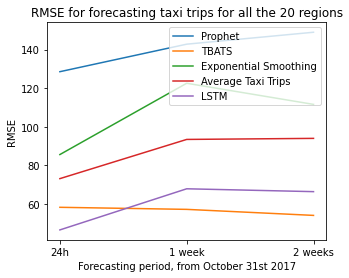

time: 148 ms


In [ ]:
simple_lstm_rmse = [46.644686852483325, 67.94192020034778, 66.46046336701686]

RMSEArrayProphet = [128.57222144386014, 142.8213660317446, 148.9988832846455]
RMSETBATS = [58.354547146888585, 57.28580350309184, 54.165096352630506]
RMSEExpSmo = [85.66843515770087, 122.58325099411775, 111.6415556452773]
totalFlows = [73.2, 93.50014880952381, 94.0453869047619]

xLabels = ["24h", "1 week", "2 weeks"]

plt.title('RMSE for forecasting taxi trips for all the 20 regions')
plt.xlabel('Forecasting period, from October 31st 2017')
plt.ylabel('RMSE')
plt.plot( xLabels,  RMSEArrayProphet)
plt.plot( xLabels,  RMSETBATS)
plt.plot( xLabels,  RMSEExpSmo)
plt.plot( xLabels,  totalFlows)
plt.plot( xLabels,  simple_lstm_rmse)
plt.legend(['Prophet', 'TBATS', 'Exponential Smoothing', 'Average Taxi Trips', "LSTM"], loc='upper right')
plt.rcParams["figure.figsize"] = (5,4)
plt.show()